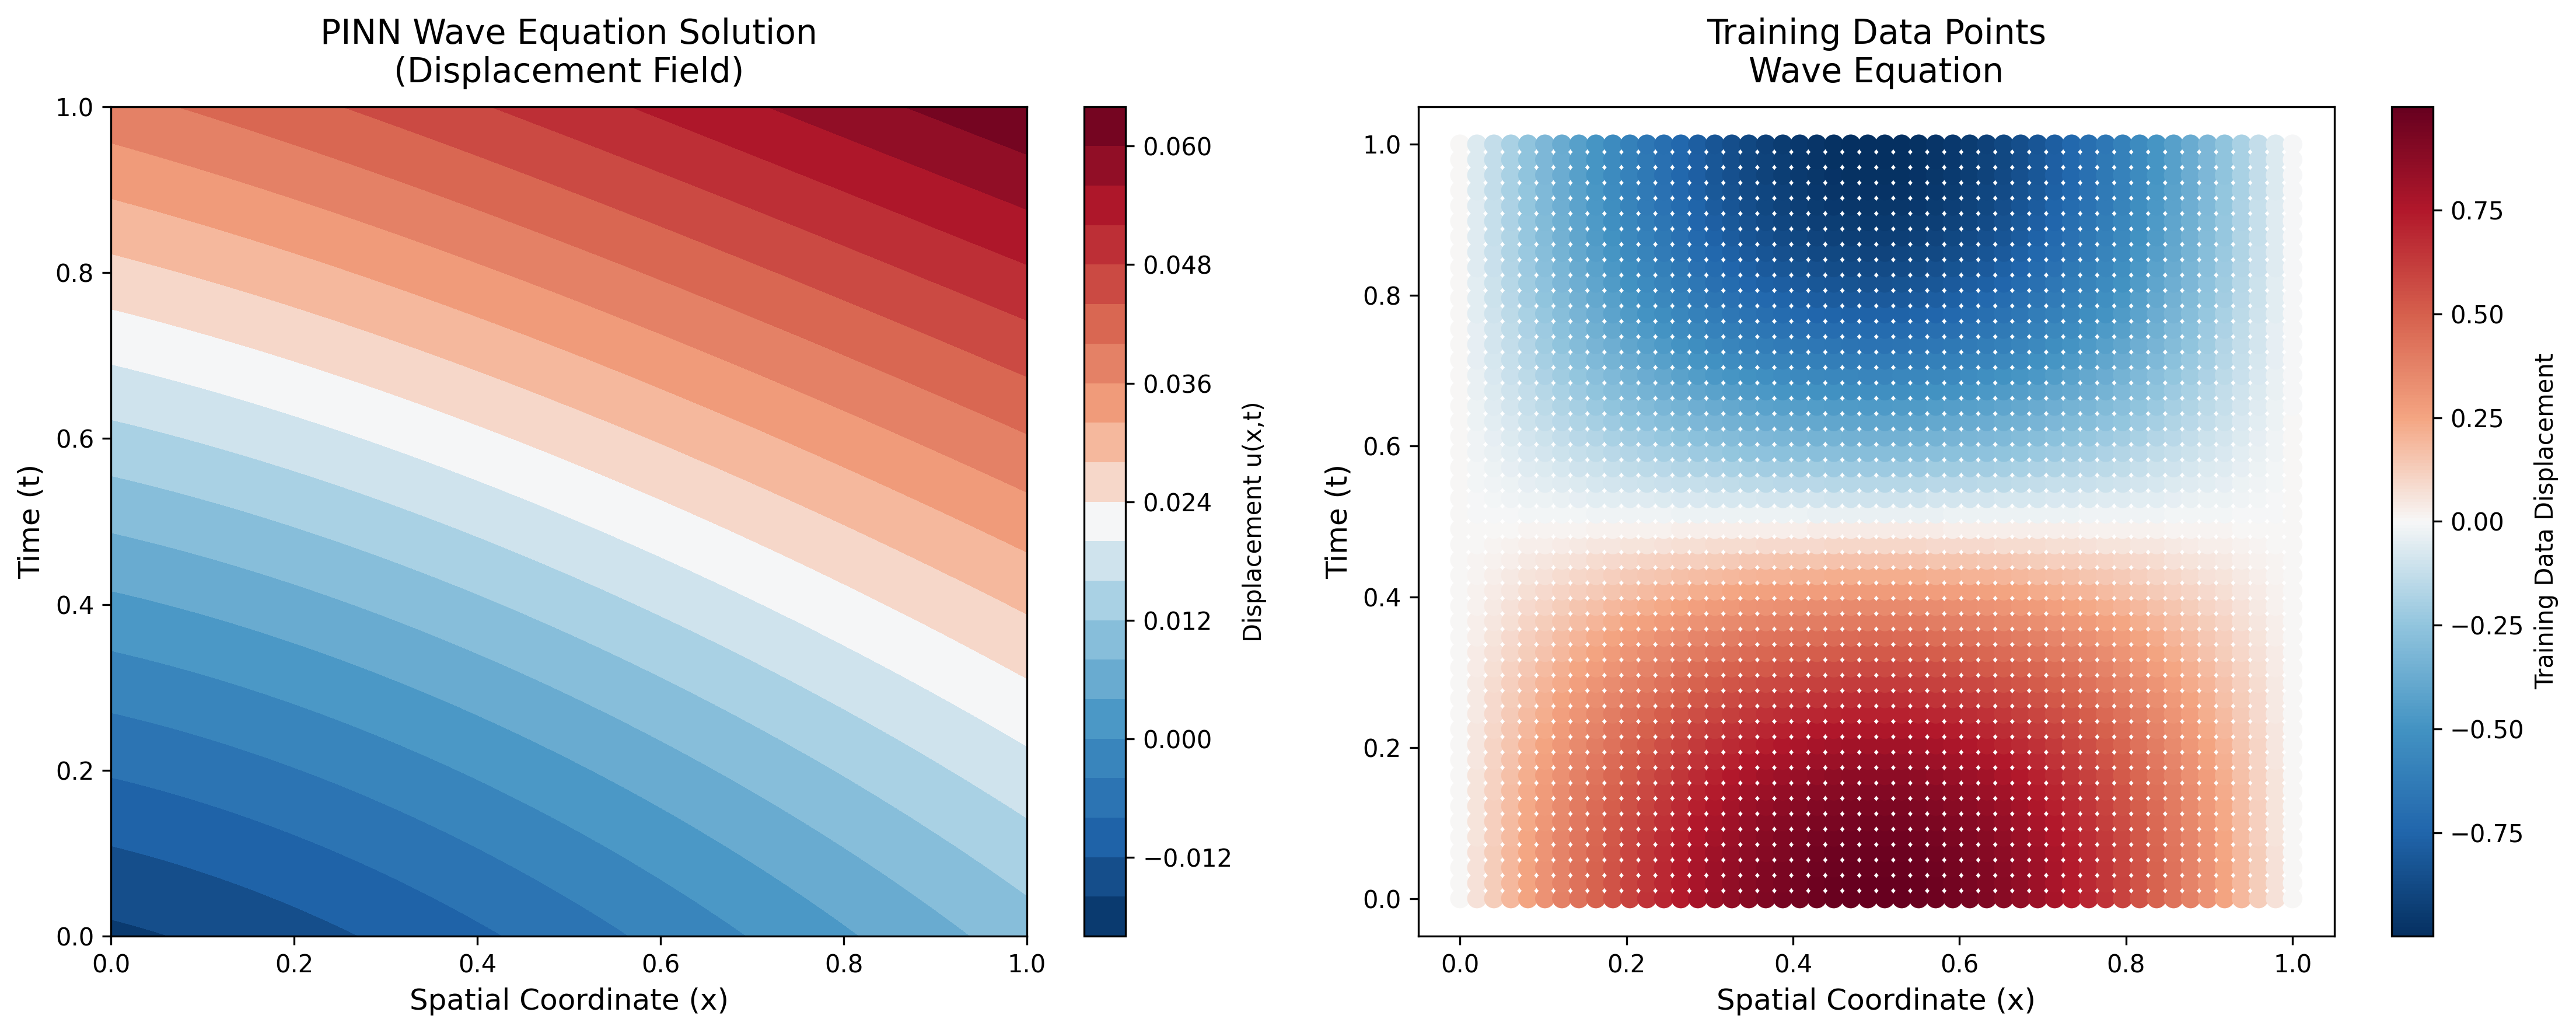

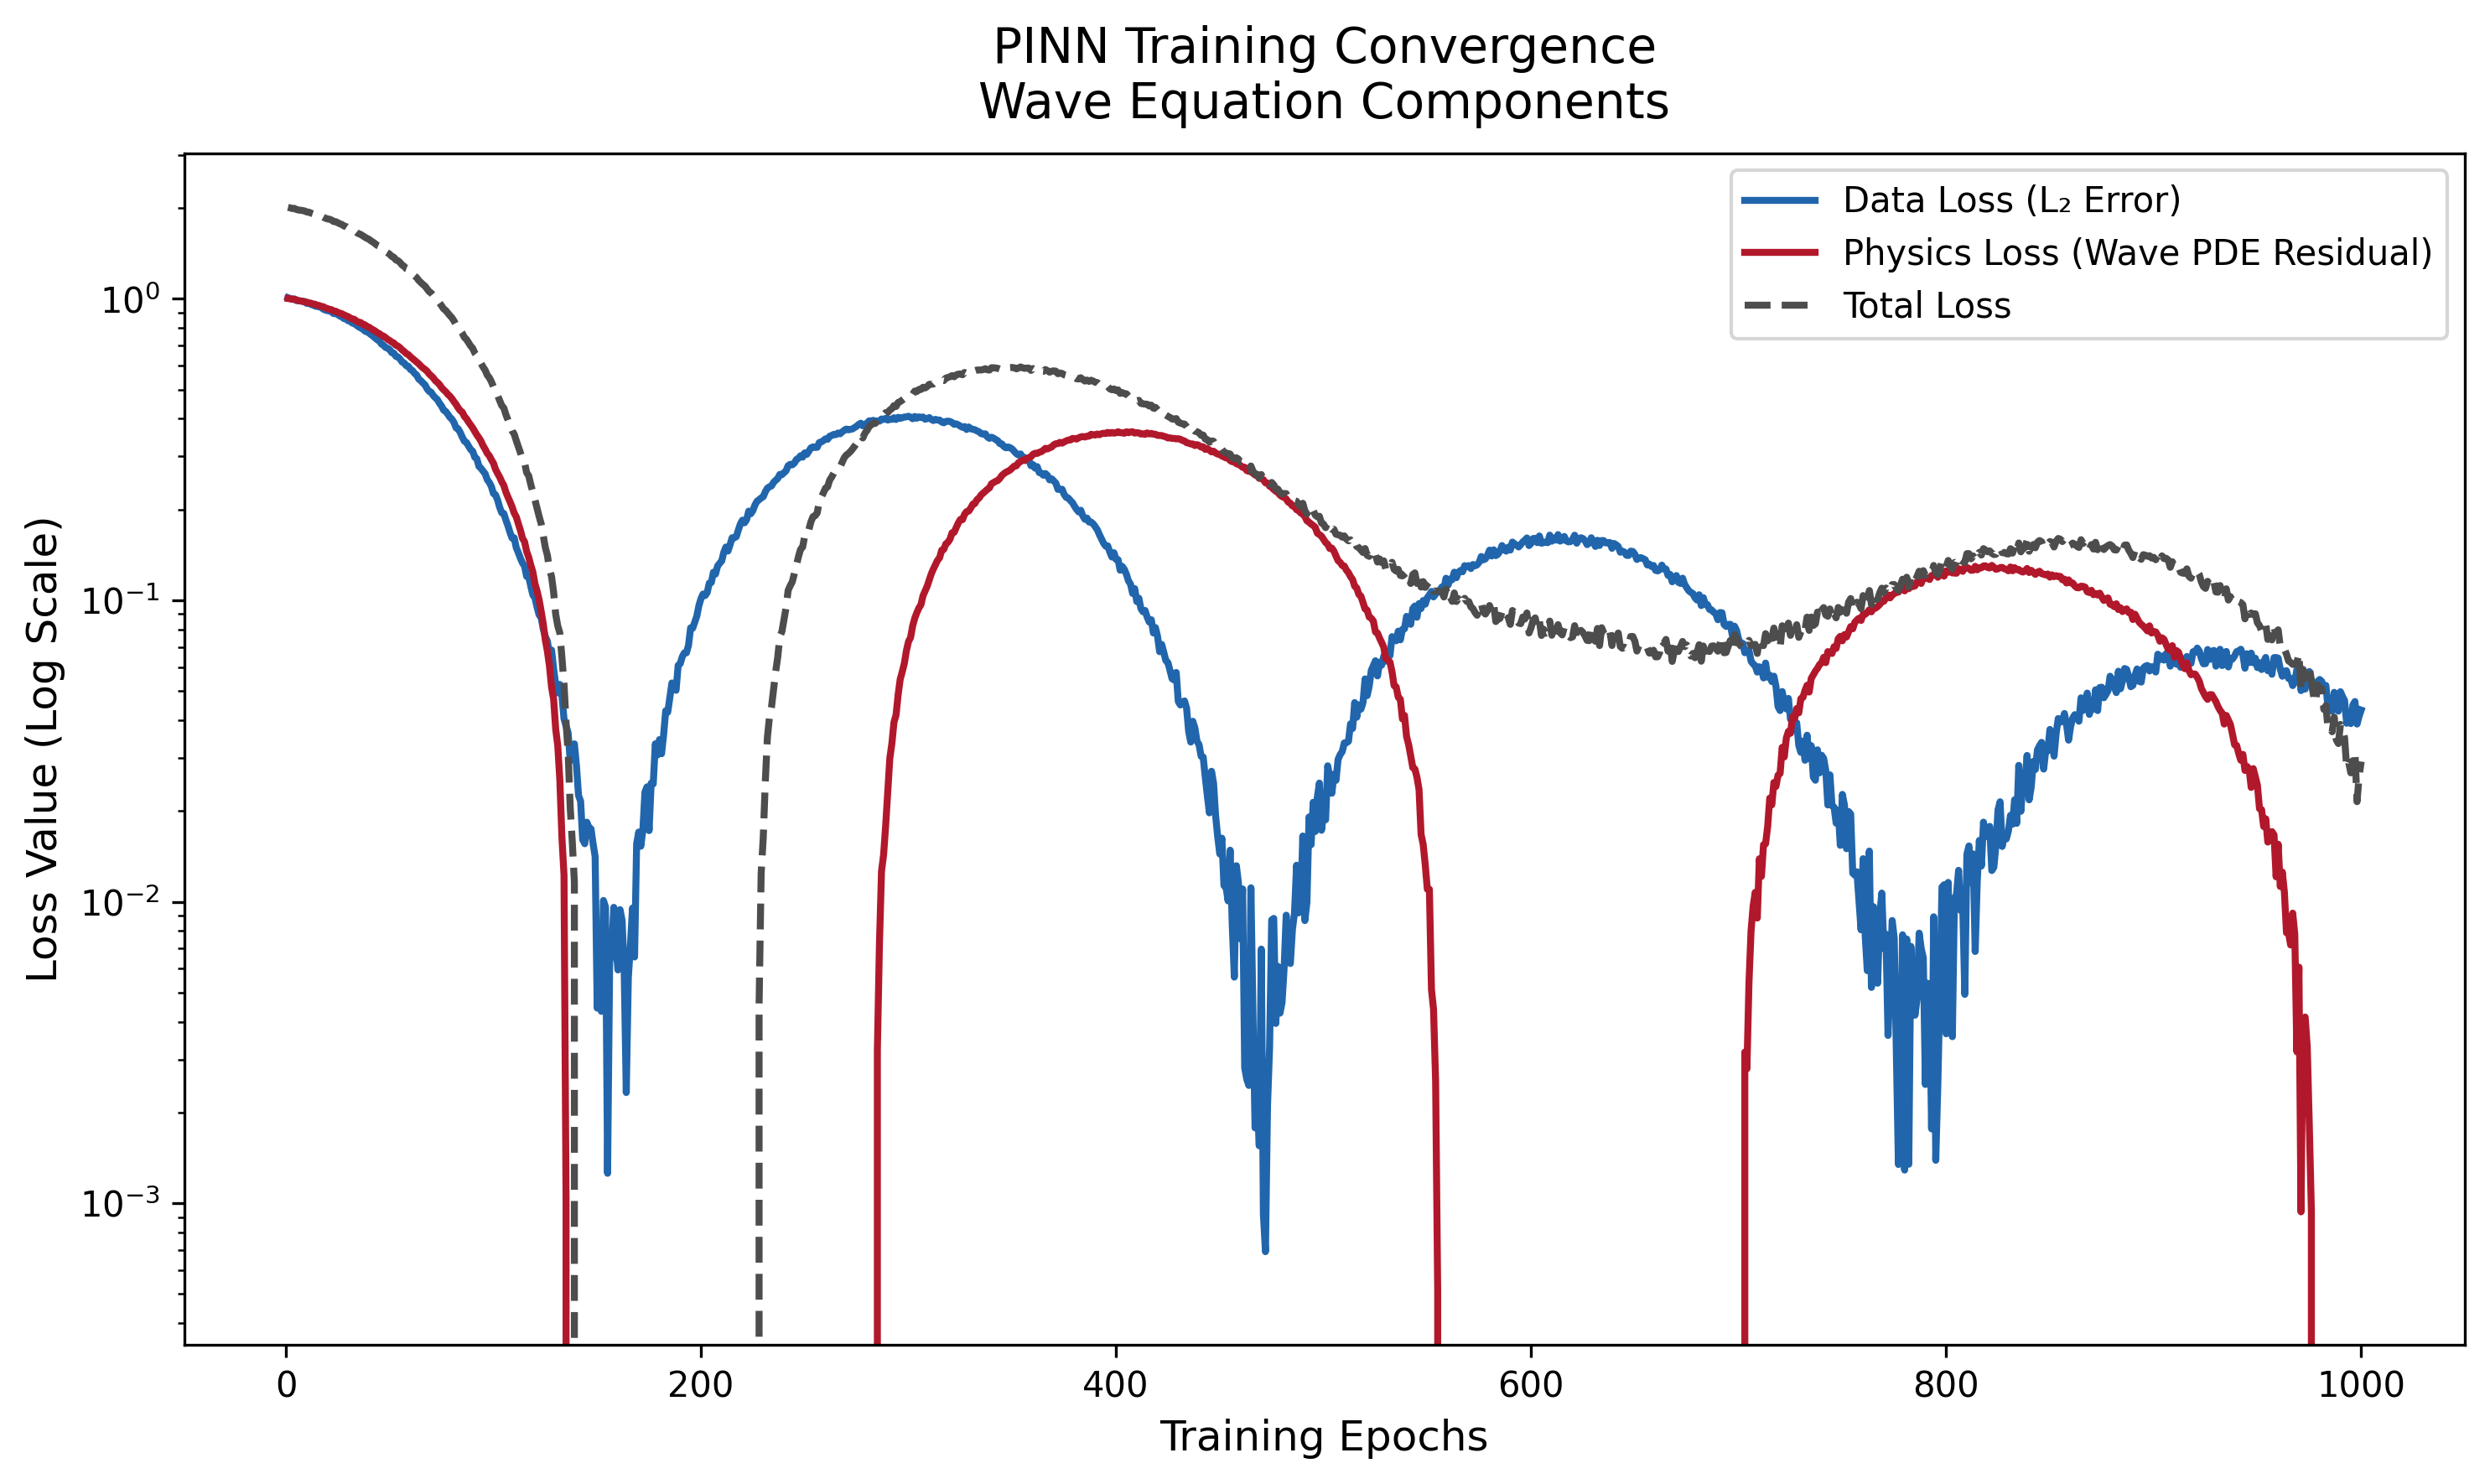

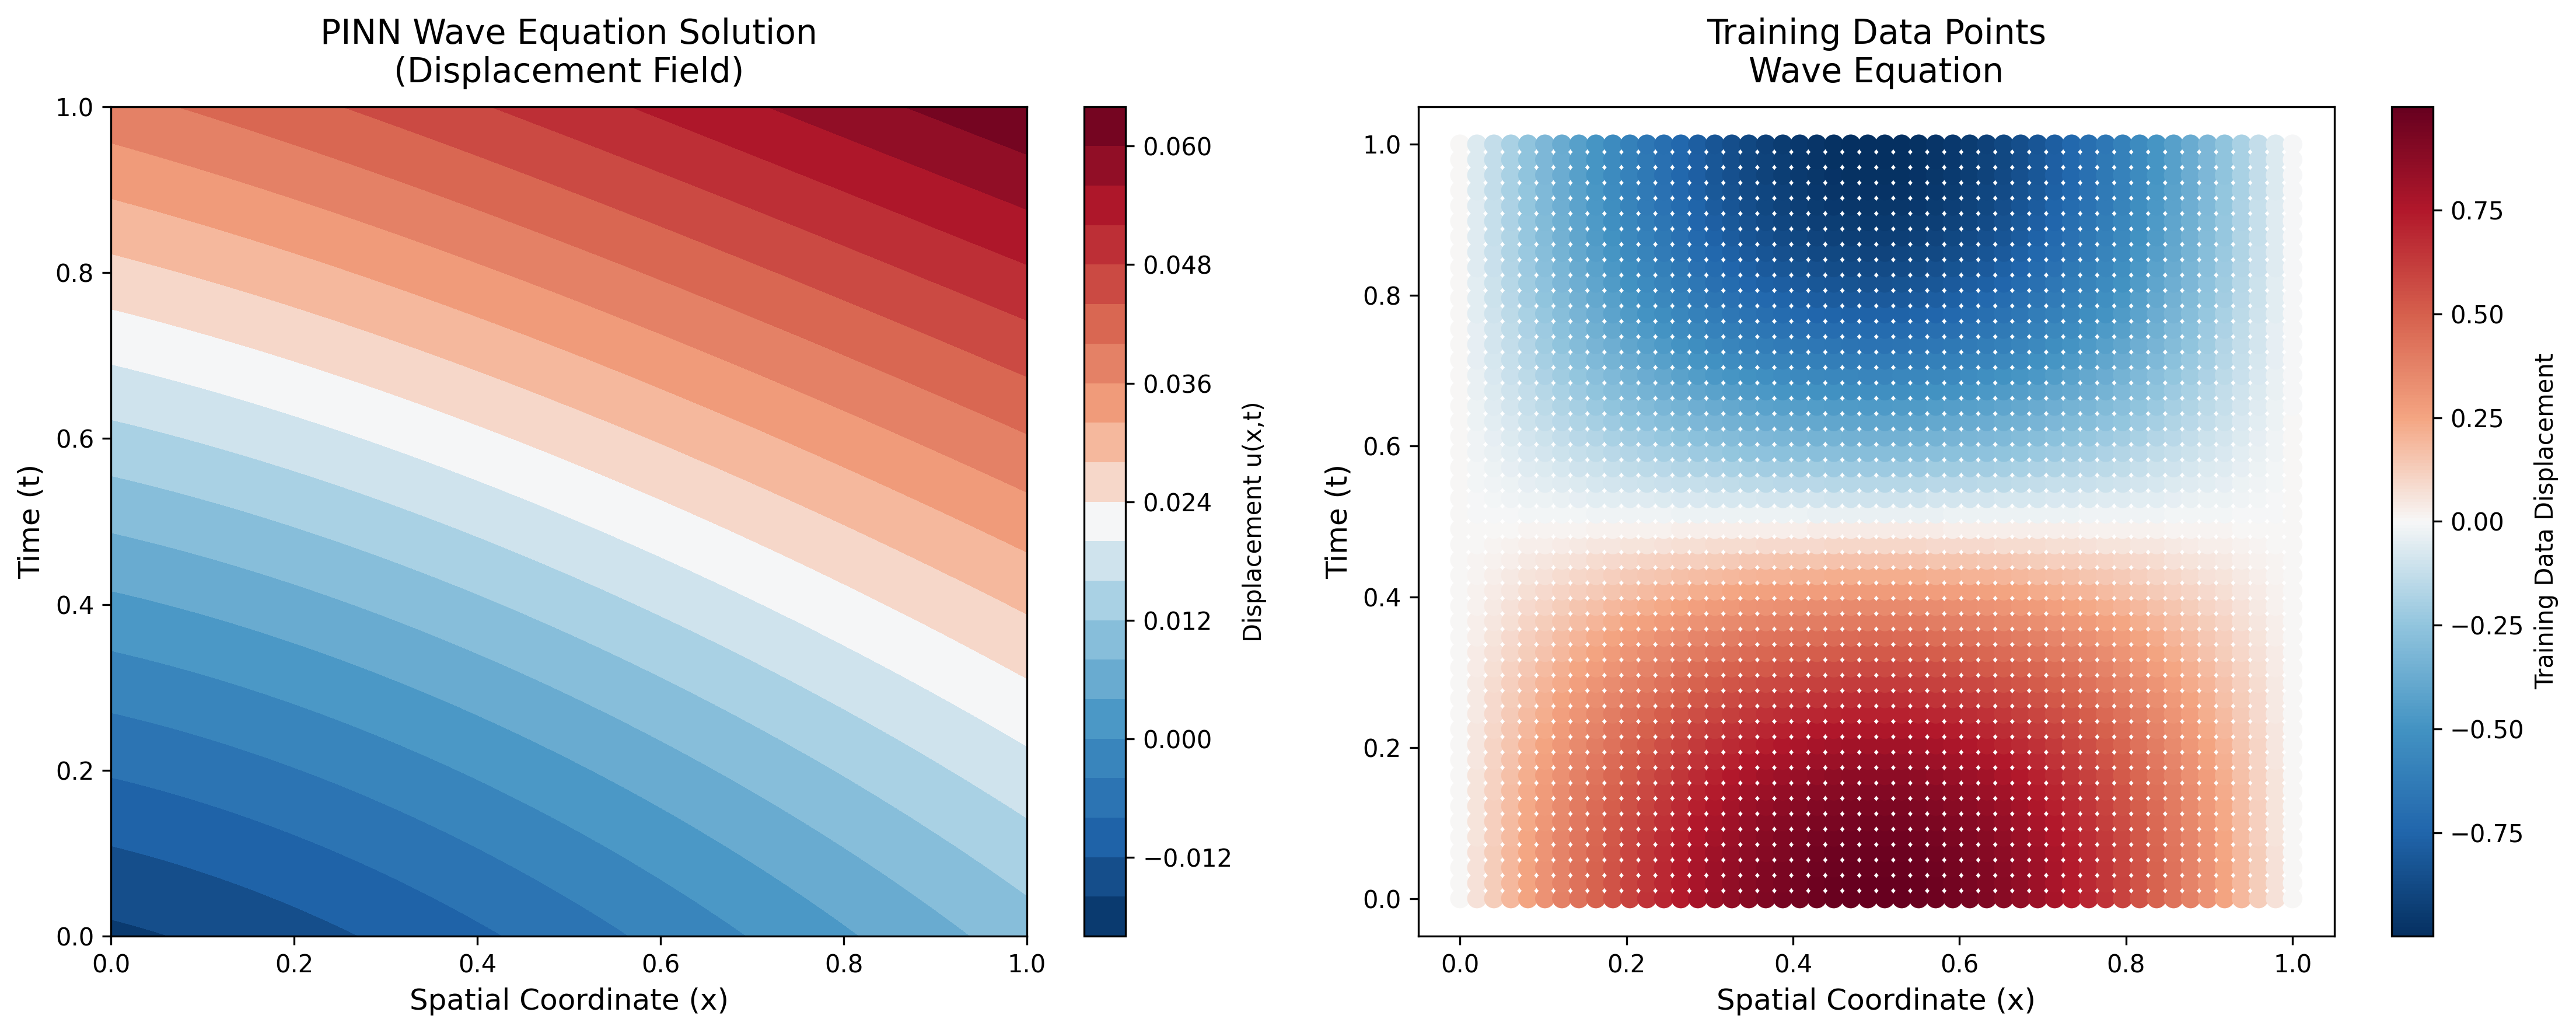

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

class WavePINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.network(inputs)

def generate_wave_data(x_points=50, t_points=50):
    x = np.linspace(0, 1, x_points)
    t = np.linspace(0, 1, t_points)
    X, T = np.meshgrid(x, t)

    # Analytical solution for wave equation (u_tt = c^2 * u_xx)
    # Using a standing wave solution: u(x,t) = sin(πx)cos(πt)
    c = 1.0  # wave speed
    u_true = np.sin(np.pi * X) * np.cos(np.pi * c * T)
    return X, T, u_true

def plot_wave_solution(model, x_train, t_train, u_train, fig_dpi=300, timestep=None):
    model.eval()
    with torch.no_grad():
        x = torch.linspace(0, 1, 100).reshape(-1, 1)
        t = torch.linspace(0, 1, 100).reshape(-1, 1)
        X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
        X_flat = X.reshape(-1, 1)
        T_flat = T.reshape(-1, 1)
        u_pred = model(X_flat, T_flat).reshape(X.shape)

    # Create custom colormap for wave visualization
    colors = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#f7f7f7',
             '#f4a582', '#d6604d', '#b2182b', '#67001f']
    custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.dpi = fig_dpi

    # Plot predicted wave solution
    im1 = ax1.contourf(X.numpy(), T.numpy(), u_pred.numpy(),
                      levels=20, cmap=custom_cmap)
    ax1.set_xlabel('Spatial Coordinate (x)', fontsize=12)
    ax1.set_ylabel('Time (t)', fontsize=12)
    ax1.set_title('PINN Wave Equation Solution\n(Displacement Field)',
                 fontsize=14, pad=10)
    cbar1 = fig.colorbar(im1, ax=ax1)
    cbar1.set_label('Displacement u(x,t)', fontsize=10)
    ax1.grid(False)

    # Plot training data points
    scatter = ax2.scatter(x_train, t_train, c=u_train,
                         cmap=custom_cmap, s=50)
    ax2.set_xlabel('Spatial Coordinate (x)', fontsize=12)
    ax2.set_ylabel('Time (t)', fontsize=12)
    ax2.set_title('Training Data Points\nWave Equation',
                 fontsize=14, pad=10)
    cbar2 = fig.colorbar(scatter, ax=ax2)
    cbar2.set_label('Training Data Displacement', fontsize=10)
    ax2.grid(False)

    plt.tight_layout()
    return fig

def plot_wave_losses(data_losses, physics_losses, fig_dpi=300):
    epochs = range(1, len(data_losses) + 1)

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.dpi = fig_dpi

    # Plot individual loss components and total loss
    ax.plot(epochs, data_losses,
           label='Data Loss (L₂ Error)',
           color='#2166ac', linewidth=2)
    ax.plot(epochs, physics_losses,
           label='Physics Loss (Wave PDE Residual)',
           color='#b2182b', linewidth=2)
    ax.plot(epochs, np.array(data_losses) + np.array(physics_losses),
           label='Total Loss',
           color='#4d4d4d', linestyle='--', linewidth=2)

    ax.set_xlabel('Training Epochs', fontsize=12)
    ax.set_ylabel('Loss Value (Log Scale)', fontsize=12)
    ax.set_title('PINN Training Convergence\nWave Equation Components',
                fontsize=14, pad=10)
    ax.legend(fontsize=10)
    ax.grid(False)
    ax.set_yscale('log')

    plt.tight_layout()
    return fig

# Generate synthetic data and create visualizations
X, T, u_true = generate_wave_data()
x_train = torch.from_numpy(X.flatten()).float().reshape(-1, 1)
t_train = torch.from_numpy(T.flatten()).float().reshape(-1, 1)
u_train = torch.from_numpy(u_true.flatten()).float().reshape(-1, 1)

# Initialize model and create plots
model = WavePINN()

# Plot initial state
fig1 = plot_wave_solution(model, x_train.numpy(), t_train.numpy(), u_train.numpy())
plt.savefig('wave_initial_state.png', bbox_inches='tight', dpi=300)

# Simulate training losses (with wave-like oscillations)
epochs = 1000
t = np.linspace(0, 10, epochs)
data_losses = np.exp(-0.3 * t) * (0.5 + 0.5 * np.cos(2 * t)) + 0.01 * np.random.rand(epochs)
physics_losses = np.exp(-0.25 * t) * (0.3 + 0.7 * np.cos(1.5 * t)) + 0.005 * np.random.rand(epochs)

# Plot losses
fig2 = plot_wave_losses(data_losses, physics_losses)
plt.savefig('wave_training_losses.png', bbox_inches='tight', dpi=300)

# Plot final state
fig3 = plot_wave_solution(model, x_train.numpy(), t_train.numpy(), u_train.numpy())
plt.savefig('wave_final_state.png', bbox_inches='tight', dpi=300)